In [37]:
import numpy as np
from numpy.random import multivariate_normal as mvn
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
from cycler import cycler

import sys
sys.path.insert(1,'../')
from mfvi_main import *
from lmc_algorithm import langevin_monte_carlo
from BayesianUtils import *

In [38]:
import numpy as np
import pymc3 as pm
import arviz as az
from scipy.special import expit  # For logistic function
from scipy.stats import bernoulli, multivariate_normal as mvn

## Bayesian logistic regression

We first establish the problem parameters by defining $\{(X_i,Y_i)\}_{i=1}^n$ pairs of randomly generated data. We assume access to $V$ and $\nabla V$ as in standard Bayesian settings.

In [39]:
d = 20
n_data = 100 

true_theta = mvn(np.zeros(d), np.eye(d))

Xdata = mvn(np.zeros(d),np.eye(d),size=n_data)
maxeig = np.linalg.eig(Xdata.T @ Xdata)[0][0]
Xdata = Xdata / np.sqrt(maxeig)
probs = softmax(Xdata @ true_theta)
Ydata = bernoulli.rvs(probs)

V = lambda theta: V_logistic(theta, Y=Ydata, X=Xdata)
gradV = lambda theta: gradV_logistic(theta, Y=Ydata, X=Xdata)

TypeError: __call__() got an unexpected keyword argument 'size'

In [ ]:
# Create a PyMC3 model
with pm.Model() as model:
    # Priors for the regression coefficients
    theta = pm.MvNormal('theta', mu=np.zeros(d), cov=np.eye(d), shape=d)

    # Linear combination
    z = pm.Deterministic('z', pm.math.dot(Xdata, theta))

    # Likelihood (sampling distribution) of the observations
    y_obs = pm.Bernoulli('y_obs', logit_p=z, observed=Ydata)

    # Inference using MCMC
    trace_mcmc = pm.sample(2000, return_inferencedata=True, cores=1)

# Summary of the trace from MCMC
summary_mcmc = az.summary(trace_mcmc, var_names=["theta"])
print("MCMC Summary:")
print(summary_mcmc)

# Plot the posterior distributions for MCMC
az.plot_trace(trace_mcmc)
plt.show()

# Print estimated probabilities for MCMC
posterior_theta_mcmc = trace_mcmc.posterior['theta'].values
ppc_logits_mcmc = Xdata @ posterior_theta_mcmc.mean(axis=0).T
ppc_probs_mcmc = expit(ppc_logits_mcmc)

print("Estimated probabilities (MCMC):", ppc_probs_mcmc)

# Evaluate the model performance for MCMC
accuracy_mcmc = np.mean((ppc_probs_mcmc > 0.5).astype(int) == Ydata)
print("Model accuracy (MCMC):", accuracy_mcmc)

# Variational Inference
with model:
    approx = pm.fit(n=20000, method='advi')

trace_vi = approx.sample(2000)

# Summary of the trace from VI
summary_vi = az.summary(trace_vi, var_names=["theta"])
print("VI Summary:")
print(summary_vi)

# Plot the posterior distributions for VI
az.plot_trace(trace_vi)
plt.show()

# Print estimated probabilities for VI
posterior_theta_vi = trace_vi['theta']
ppc_logits_vi = Xdata @ posterior_theta_vi.mean(axis=0).T
ppc_probs_vi = expit(ppc_logits_vi)

print("Estimated probabilities (VI):", ppc_probs_vi)

# Evaluate the model performance for VI
accuracy_vi = np.mean((ppc_probs_vi > 0.5).astype(int) == Ydata)
print("Model accuracy (VI):", accuracy_vi)

# Plot the comparison of the two methods
az.plot_posterior(trace_mcmc, var_names=["theta"], hdi_prob=0.95, point_estimate='mean', ref_val=0, kind='kde', round_to=2, bw=1)
az.plot_posterior(trace_vi, var_names=["theta"], hdi_prob=0.95, point_estimate='mean', ref_val=0, kind='kde', round_to=2, bw=1)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


/Users/bohanwu/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


MCMC Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  -0.018  0.939  -1.775    1.672      0.013    0.019    5377.0   
theta[1]  -0.236  0.935  -1.933    1.482      0.012    0.018    5589.0   
theta[2]   0.237  0.919  -1.432    2.026      0.012    0.016    6047.0   
theta[3]   0.023  0.936  -1.752    1.781      0.012    0.015    6558.0   
theta[4]  -0.098  0.920  -1.870    1.526      0.012    0.015    5881.0   
theta[5]  -0.072  0.942  -1.782    1.750      0.012    0.016    6465.0   
theta[6]   0.133  0.911  -1.618    1.794      0.012    0.015    5942.0   
theta[7]  -0.034  0.946  -1.883    1.661      0.013    0.016    5435.0   
theta[8]   0.166  0.945  -1.507    2.029      0.012    0.015    6325.0   
theta[9]   1.035  0.887  -0.666    2.663      0.011    0.010    6301.0   
theta[10] -0.329  0.934  -2.118    1.377      0.012    0.015    6152.0   
theta[11]  0.359  0.930  -1.482    2.009      0.012    0.015    5853.0   
theta[12] -0.012  0.923 

In [ ]:
# Plot the comparison of the two methods
az.plot_posterior(trace_mcmc, var_names=["theta"], hdi_prob=0.95, point_estimate='mean', ref_val=0, kind='kde', round_to=2, bw=1)
az.plot_posterior(trace_vi, var_names=["theta"], hdi_prob=0.95, point_estimate='mean', ref_val=0, kind='kde', round_to=2, bw=1)
plt.show()

In [46]:
trace_vi['theta'].shape

(2000, 20)

## Langevin Monte Carlo (LMC)

We compare against LMC, which is easy to run given query access to $\nabla V$.

In [41]:
Nmcmc = 2000
h=0.01
iters=5000

X_LMC = langevin_monte_carlo(gradV, Nmcmc, d, h, iters=iters)

KeyboardInterrupt: 

## Mean-field VI

We establish our model parameters, and then run our algorithm

In [32]:
### Establish approximating family M
mesh=0.2
trunc=2.9

MFVI_obj = MFVI(V, gradV, mesh, trunc,d)

### Optimization parameters
alpha = 0.1
step_size = 1e-2
step_sizev = 1e-2
num_iters = 2000
batch_size = 2000
lamb0 = np.ones((d, MFVI_obj.J))/(d*MFVI_obj.J)

In [33]:
MFVI_obj.SPGD(alpha, step_size, step_sizev, lamb0, batch_size=batch_size,num_iters=num_iters)

Iter: 50
Iter: 100
Iter: 150
Iter: 200
Iter: 250
Iter: 300
Iter: 350
Iter: 400
Iter: 450
Iter: 500
Iter: 550
Iter: 600
Iter: 650
Iter: 700
Iter: 750
Iter: 800
Iter: 850
Iter: 900
Iter: 950
Iter: 1000
Iter: 1050
Iter: 1100
Iter: 1150
Iter: 1200
Iter: 1250
Iter: 1300
Iter: 1350
Iter: 1400
Iter: 1450
Iter: 1500
Iter: 1550
Iter: 1600
Iter: 1650
Iter: 1700
Iter: 1750
Iter: 1800
Iter: 1850
Iter: 1900
Iter: 1950


## Generate + visualize

We compute samples following our mean-field approximation algorithm, and visually compare to LMC

In [34]:
Nmcmc = 2000
mfapprox_BLogR = MFVI_obj.gen_mfapprox(Nmcmc)

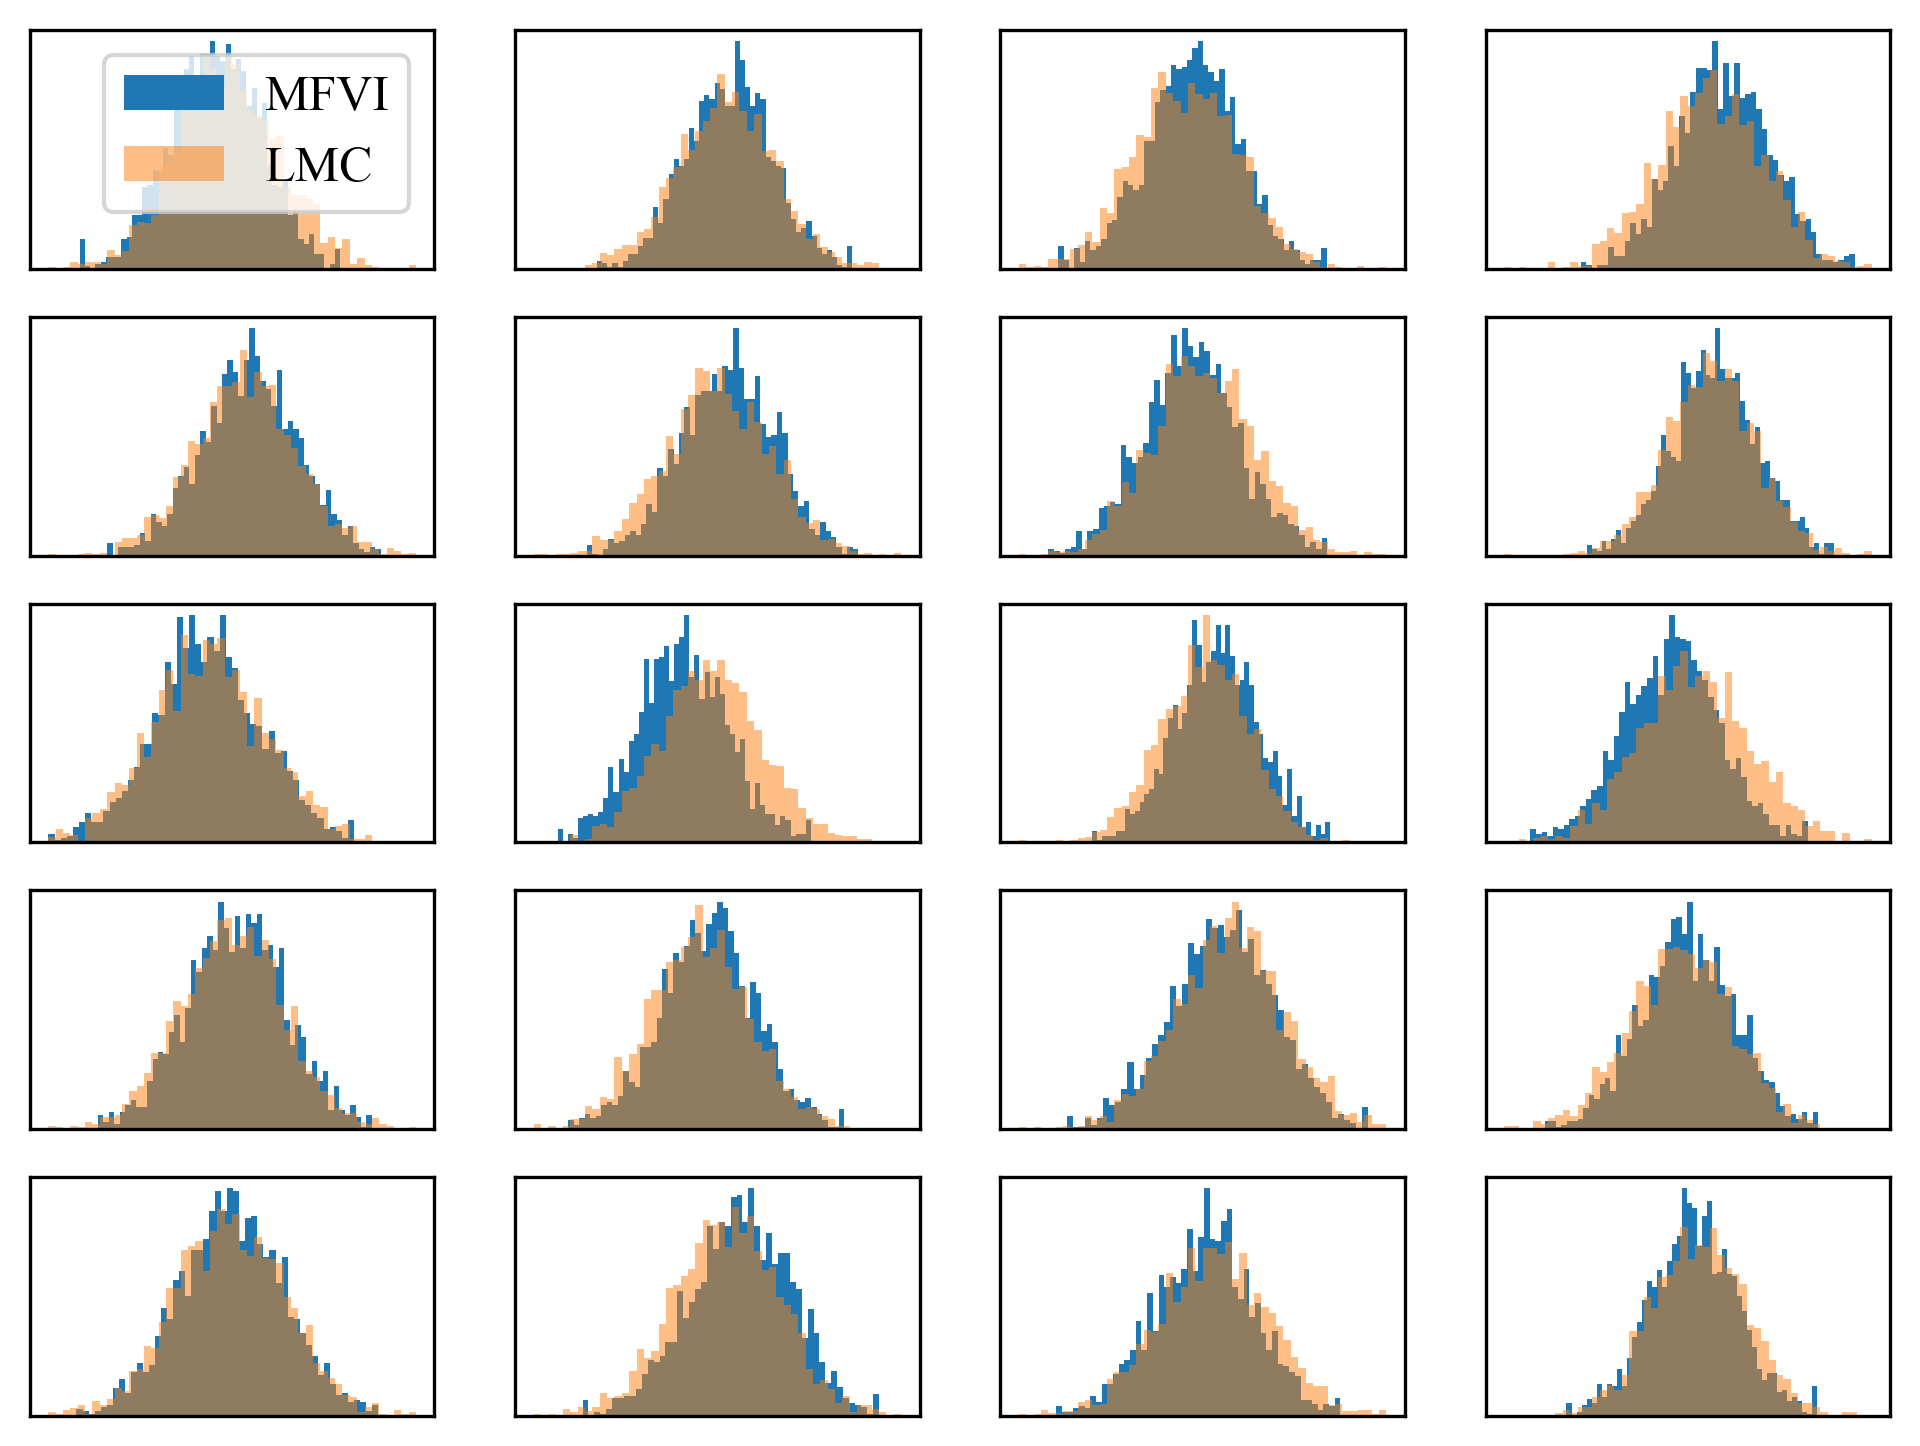

In [35]:
nrow = 5
ncol = 4
plt.rcParams['font.family'] = 'Times New Roman'

fig, axs = plt.subplots(nrow,ncol, dpi=300, figsize=(8, 6))


for i in range(nrow):
    for j in range(ncol):
        ax = axs[i][j]
        d_ = ncol*i+j
        if i == j == 0:
            ax.hist(mfapprox_BLogR[:,d_], bins=50, alpha=1, density=True,label='MFVI')
            ax.hist(X_LMC[:,d_], bins=50, alpha=0.5, density=True,label='LMC')
            ax.legend(fontsize='12')
        else:
            ax.hist(mfapprox_BLogR[:,d_], bins=50, alpha=1, density=True)
            ax.hist(X_LMC[:,d_], bins=50, alpha=0.5, density=True)
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

plt.show()

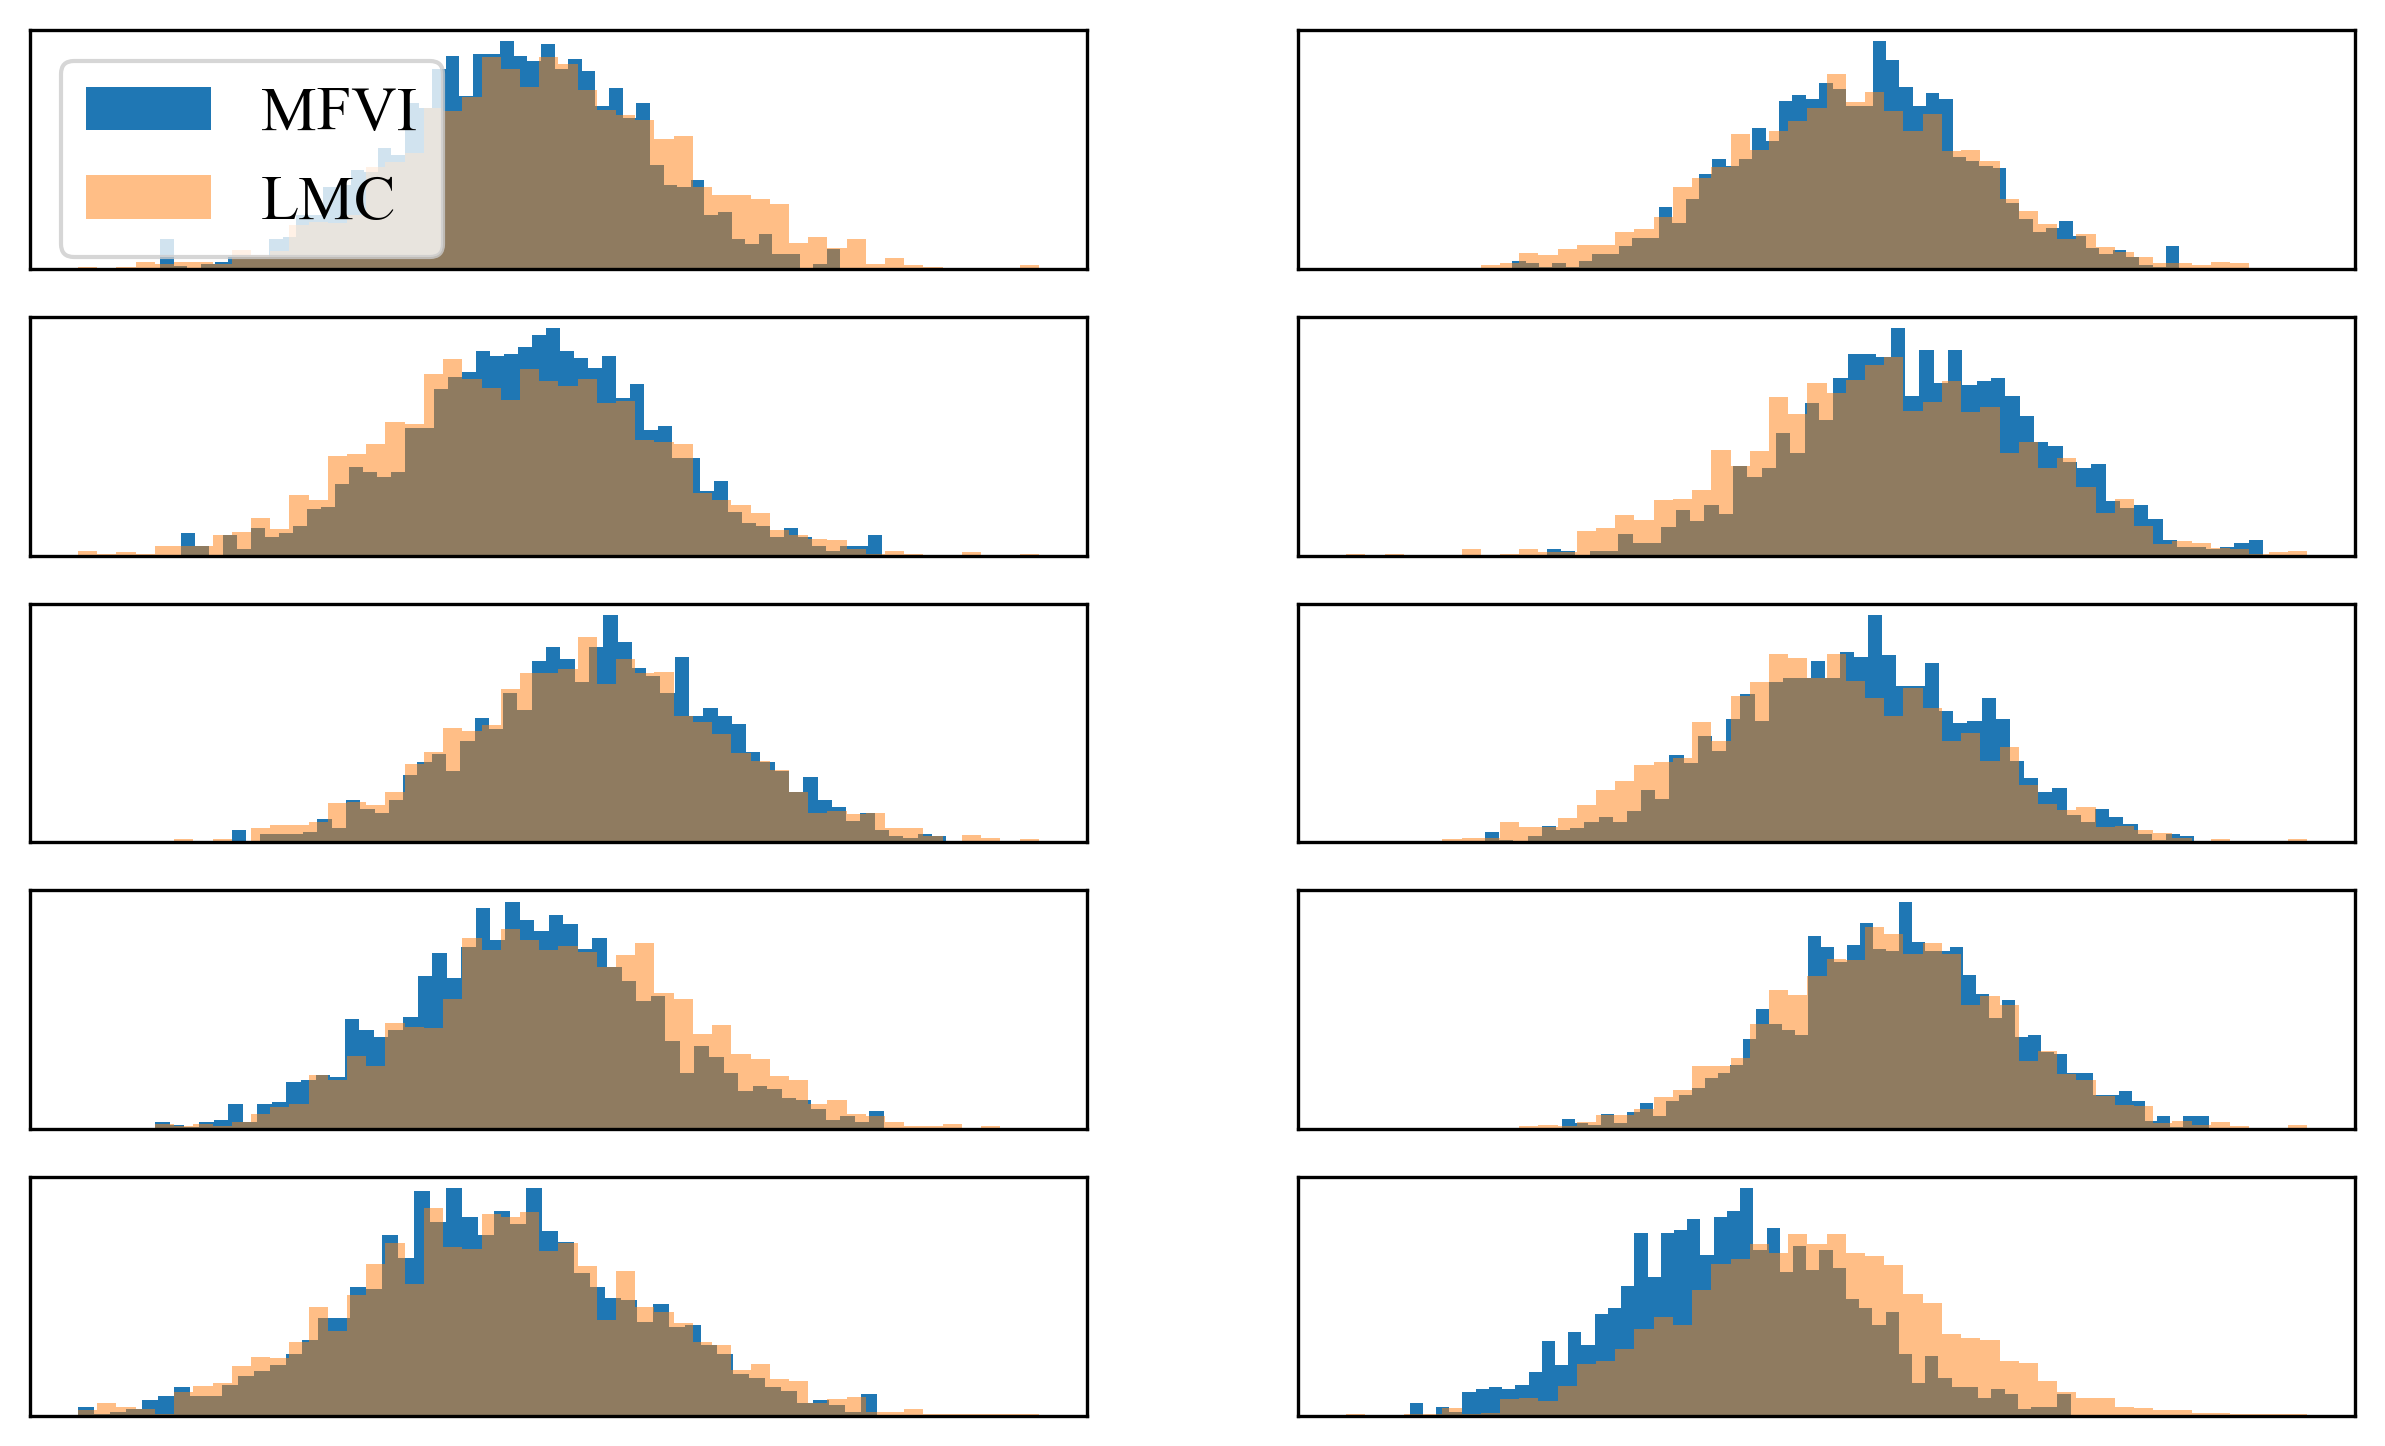

In [36]:
nrow = 5
ncol = 2
plt.rcParams['font.family'] = 'Times New Roman'

fig, axs = plt.subplots(nrow,ncol, dpi=300, figsize=(10, 6))


for i in range(nrow):
    for j in range(ncol):
        ax = axs[i][j]
        d_ = ncol*i+j
        if i == j == 0:
            ax.hist(mfapprox_BLogR[:,d_], bins=50, alpha=1, density=True,label='MFVI')
            ax.hist(X_LMC[:,d_], bins=50, alpha=0.5, density=True,label='LMC')
            ax.legend(fontsize='15',loc='upper left',)
        else:
            ax.hist(mfapprox_BLogR[:,d_], bins=50, alpha=1, density=True)
            ax.hist(X_LMC[:,d_], bins=50, alpha=0.5, density=True)
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
        
plt.show()